In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
d = pd.read_excel("/content/Data.xlsx")
res1 = d["Result 1"]
res2 = d["Result 2"]
x_d = np.column_stack((res1,res2))
dg = pd.read_excel("/content/Data_GMM.xlsx")
res1g = dg["Result 1"]
res2g = dg["Result 2"]
x_dg = np.column_stack((res1g,res2g))

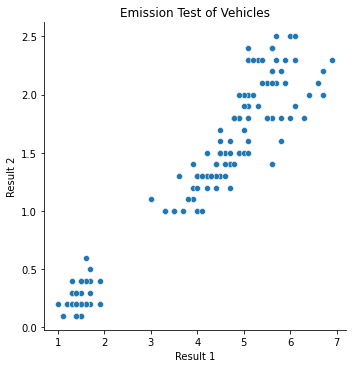

In [3]:
# Question 2a
sns.relplot(x = res1, y = res2).set(title = "Emission Test of Vehicles")

Mean for cluster 0: [4.92525253 1.68181818]
Mean for cluster 1: [1.49215686 0.2627451 ]


[Text(0.5, 1.0, 'K-Means Clustering on Data.xlsx')]

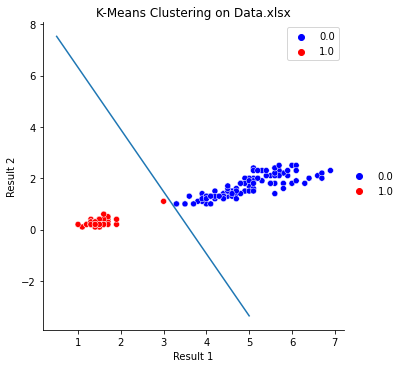

In [4]:
# Question 2b
# K-Means Clustering
def closest_mean(x,means):
  k = means.shape[0]
  class_map = np.ones(x.shape[0],dtype=np.float64)
  for i in range(x.shape[0]):
    class_map[i] = np.argmin(np.sqrt(np.sum(np.square(x[i] - means),axis = 1)))
  return class_map

def mean_point(x,class_map,k):
  dim = x.shape[1]
  mean = np.zeros((k,dim))
  for i in range(k):
    mean[i] = np.mean(x[class_map == i],axis=0)
  return mean 

k = 2 # We know we have to separate the points into 2 clusters
means = np.zeros((k,x_d.shape[1]))
# Random Initialisation of the mean points
random_index = np.random.permutation(x_d.shape[0])
means = x_d[random_index[:2],:]

for i in range(10):
  map = closest_mean(x_d,means)
  means = mean_point(x_d,map,k)

# Plotting the data points
sns.relplot(x = res1,y = res2,hue = map,palette=["b", "r"])
print("Mean for cluster 0:",means[0])
print("Mean for cluster 1:",means[1])
x_coord = np.linspace(0.5,5,100)
slope = ((means[0][0]-means[1][0])/(means[1][1]-means[0][1]))
y_c = (means[0][1]+means[1][1])/2 + slope*(x_coord-((means[0][0]+means[1][0])/2))
sns.lineplot(x = x_coord, y = y_c, palette='g').set(title = "K-Means Clustering on Data.xlsx")

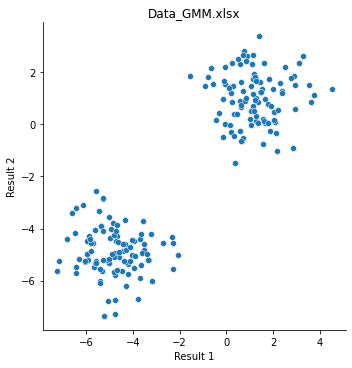

In [5]:
# Question 2c
sns.relplot(x = res1g, y = res2g).set(title = "Data_GMM.xlsx")

In [8]:
# GMM
from scipy.stats import multivariate_normal
k_g = 2 # Given
# Initialise the required values
pi_g = np.ones(k,dtype = np.float64)
theta_g = np.ones((x_dg.shape),dtype = np.float64)
rand_ind = np.random.permutation(x_dg.shape[0])
mu_g = x_dg[rand_ind[:k_g],:]
sigma_g = [np.cov(x_dg.T) for i in range(k)]

def get_theta(x):
  a = np.zeros((x_dg.shape[0],k_g))
  for i in range(k_g):
    dis = multivariate_normal(mean = mu_g[i], cov = sigma_g[i])
    a[:,i] = dis.pdf(x_dg)
  num = a*pi_g
  den = np.sum(num,axis=1)[:,np.newaxis]
  theta = num/den
  return theta

def expectation(x):
  theta = get_theta(x)
  pi = np.mean(theta,axis=0)
  return theta,pi

def maximization(x):
  for i in range(k_g):
    t = theta_g[:,[i]]
    t_sum = np.sum(t)
    mu_g[i] = np.sum(x_dg*t,axis=0)/t_sum
    sigma_g[i] = np.cov(x_dg.T,aweights = (t/t_sum).flatten(), bias = True)
  return mu_g,sigma_g 

for i in range(100):
  theta_g,pi_g = expectation(x_dg)
  mu_g,sigma_g = maximization(x_dg)

print("Mean for Cluster 0:",mu_g[0])
print("Mean for Cluster 1:",mu_g[1])
print("Covariance Matrix for Cluster 0 : \n",sigma_g[0])
print("Covariance Matrix for Cluster 1 : \n",sigma_g[1])
print("Weights : ",pi_g)

Mean for Cluster 0: [1.19721315 1.00893775]
Mean for Cluster 1: [-4.81815103 -4.87158388]
Covariance Matrix for Cluster 0 : 
 [[1.19169015 0.00910693]
 [0.00910693 0.97049735]]
Covariance Matrix for Cluster 1 : 
 [[ 1.16968737 -0.10528566]
 [-0.10528566  0.80018909]]
Weights :  [0.5 0.5]


Text(0.5, 1.0, 'GMM clusters with centres')

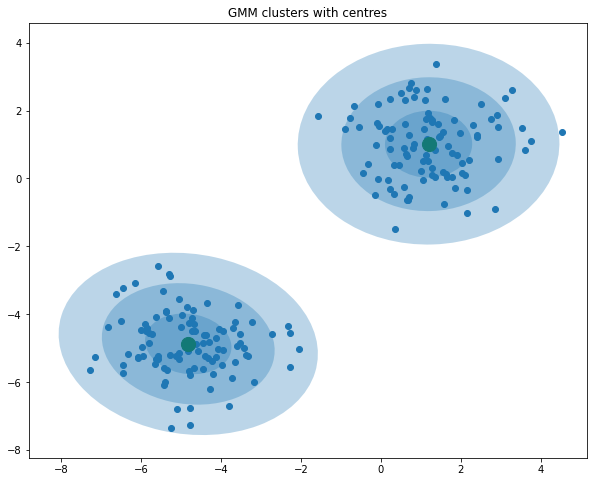

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None,**kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,angle,**kwargs))

plt.figure(figsize = (10,8))
plt.scatter(x_dg[:, 0], x_dg[:, 1])
centers = np.zeros((2,2))
for i in range (2):
    plt.scatter(mu_g[i].item(0),mu_g[i].item(1),c='green',s=200,alpha = 1)
for pos, covar, w in zip(mu_g, sigma_g, pi_g):
    draw_ellipse(pos, covar, alpha=0.3)
plt.title('GMM clusters with centres')       